# City and Resort Hotels bookings forecast

## Topic

In this notebook I'm going to be forecasting room bookings for 2 Hotels : The city Hotel and the Resort Hotel.The data set contains booking information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things. All personally identifying information has been removed from the data.
Before I start with the forecasting part I would like to dive deeper into the dataset and try to understand some of its properties such as the type of clients that are mostly received, the booking agents that bring in the most business, the kind of pension people tend to take, among other information. Then for the forecast part I will use ETS models, ARIMA models and a Prophet model, compare the results and choose the best model for the dataset.

## Objectives

- Gain more insight into the business of the two hotels
- Forecast future bookings

## Summary

- Importing Libraries
- The Dataset
- Exploratory Data Analysis
- City Hotel :
    - ETS Model : Holt Winter's Seasonal method
    - ARIMA Model : SARIMA
    - Prophet Model
    - Comparing Models performences
    - Making forecasts with confidence intervals
- Resort Hotel:
    - ETS Model : Holt Winter's Seasonal method
    - ARIMA Model : SARIMA
    - Prophet Model
    - Comparing Models performences
    - Making forecasts with confidence intervals
- Conclusion

## Importing libraries

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
import statsmodels.api as sm
# ETS models
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
# checking for stationarity
from statsmodels.tsa.stattools import adfuller
# transform the target variable to resemble a normal distribution
# ARIMA model
from pmdarima import auto_arima
# for forecasting
from prophet import Prophet
# Models validation
from sklearn.metrics import mean_squared_error,mean_absolute_error
# Calculate the Akaike Information Criterion
from astropy.stats.info_theory import akaike_info_criterion_lsq
# Autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
# For date time
from datetime import datetime

# The Dataset

In [2]:
df = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Hotel_bookings-forecast\hotel_bookings.csv', sep =",")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

The dataset contains a lot of information about 2 hotels' bookings : The city hotel and the resort hotel, some of the most important information in the dataset is :

- the time of arrival
- the length of the stay
- the type of room assigned
- costumer type
- distribution channel 

I'm only going to use the features that I belive would help get deep insight of the data, and since my goal in this project is to forecast the bookings of both hotels I will be making a column to keep track of the date of the booking.


In [5]:
df = df.drop(columns=["is_canceled", "lead_time","stays_in_weekend_nights","stays_in_week_nights",
                    "previous_cancellations","previous_bookings_not_canceled","assigned_room_type",
                    "booking_changes","deposit_type","agent","company","days_in_waiting_list","adr",
                    "required_car_parking_spaces","total_of_special_requests","reservation_status","reservation_status_date",
                     "arrival_date_week_number", "adults", "children", "babies","market_segment","is_repeated_guest"])

In [6]:
df["arrival_date_month"] = df["arrival_date_month"].replace({"January": 1, "February": 2, "March": 3, "April": 4,
                                                             "May":5, "June": 6, "July":7, "August":8, "September":9,
                                                             "October": 10, "November": 11, "December":12
    
})
   

In [7]:
df["arrival_date"] = df["arrival_date_year"].astype(str) + "-" + df["arrival_date_month"].astype(str) 

In [8]:
df["arrival_date"] = df["arrival_date"].astype(str) + "-" + df["arrival_date_day_of_month"].astype(str)

In [9]:
df = df.drop(columns=["arrival_date_year","arrival_date_month","arrival_date_day_of_month"])

In [10]:
df.head()

,hotel,meal,country,distribution_channel,reserved_room_type,customer_type,arrival_date
0,Resort Hotel,BB,PRT,Direct,C,Transient,2015-7-1
1,Resort Hotel,BB,PRT,Direct,C,Transient,2015-7-1
2,Resort Hotel,BB,GBR,Direct,A,Transient,2015-7-1
3,Resort Hotel,BB,GBR,Corporate,A,Transient,2015-7-1
4,Resort Hotel,BB,GBR,TA/TO,A,Transient,2015-7-1


In [11]:
df["arrival_date"] = pd.to_datetime(df["arrival_date"])

In [12]:
df.dtypes

hotel                           object
meal                            object
country                         object
distribution_channel            object
reserved_room_type              object
customer_type                   object
arrival_date            datetime64[ns]
dtype: object

# Exploratory Data Analysis

In [13]:
country = df.copy()
country["count"] = 1

In [14]:
country = country.groupby("country").sum().reset_index()

In [15]:
country = country.sort_values(by="count", ascending= False)

In [16]:
country = country.head(10)

<AxesSubplot:xlabel='count', ylabel='country'>

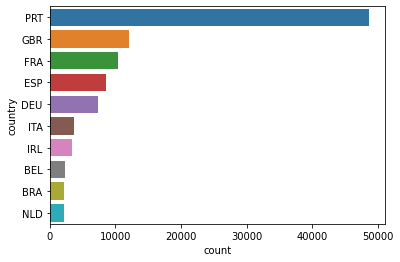

In [17]:
sns.barplot(data=country, x="count", y="country")

The barplot above shows the top 10 countries of travelers that stay in the city and resort hotels, the majority of guests come from Portugal with over 50 000 guests, followed by Grand Britain and France. It looks that the european market is dominant and offers the most business to the company.

In [18]:
pension = df.copy()
pension["count"] = 1
pension = pension.groupby("meal").sum().reset_index()

In [19]:
pension = pension.sort_values(by="count", ascending = False)

<AxesSubplot:xlabel='count', ylabel='meal'>

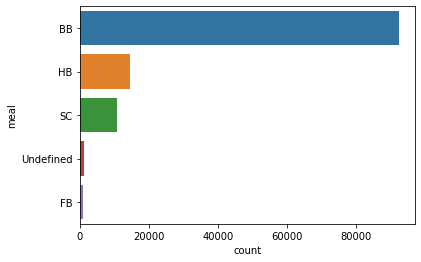

In [20]:
sns.barplot(data= pension, x="count",  y=("meal"))

Here we see the type of pension booked by the guests of our two hotels, the majority of them book bed and breakfast service, followed by Half board or bed plus breakfast and dinner. The other kind of pension that people order is SC or self catering ie no meals come with the room. Finally a small portion of the guests have undefined pensions and the smallest portion of all take the all inclusive option.

In [21]:
channel = df.copy()
channel["count"] = 1
channel = channel.groupby("distribution_channel").sum().reset_index()
channel = channel.sort_values(by= "count", ascending = False)

<AxesSubplot:xlabel='count', ylabel='distribution_channel'>

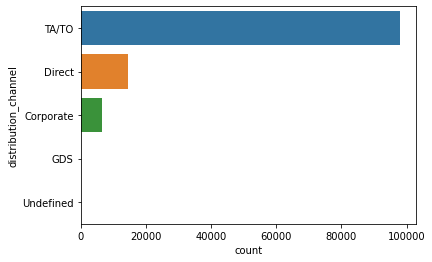

In [22]:
sns.barplot(data= channel, x="count", y="distribution_channel")

Here I can see that the majority of bookings are made through TA/TO which I assume is a travel booking plateform (I wasn't able to find anything while searching for it). A small portion of the guests books directly at the reception desk, and an even smaller portion book through their company. I can deduce that most people who visit the hotels do it for the leisure purposes, and only a tiny portion do it for business purposes.

In [23]:
customer = df.copy()
customer["count"] = 1
customer = customer.groupby("customer_type").sum().reset_index()

In [24]:
customer = customer.sort_values(by="count", ascending = False)

<AxesSubplot:xlabel='count', ylabel='customer_type'>

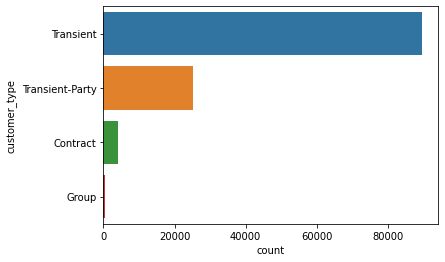

In [25]:
sns.barplot(data = customer, x = "count", y="customer_type")

The barplot above shows us the types of guests the hotels receive, most clients are transient or partially transient ie they only stay in the hotel for a short period of time. A small portion represents clients who have contract with the hotel to stay for a long period and a tiny portion is for clients that come in groups.

In [26]:
rooms = df.copy()
rooms["count"] = 1
rooms = rooms.groupby("reserved_room_type").sum().reset_index()

In [27]:
rooms = rooms.sort_values(by="count", ascending = False)

<AxesSubplot:xlabel='count', ylabel='reserved_room_type'>

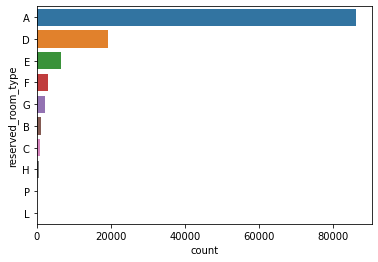

In [28]:
sns.barplot(data=rooms, x = 'count',y='reserved_room_type')

Here I can simply see the types of rooms that are booked by the guests, most guests book type A rooms, type D is also popular among the guests.

In [29]:
df = df.drop(columns=["meal", "country", "distribution_channel","reserved_room_type","customer_type"])

In [30]:
city = df[df["hotel"] == "City Hotel"]

In [31]:
resort = df[df["hotel"] == "Resort Hotel"]

So, after having a quick insight of the data, I deleted all the columns except the one that keeps track of the kind of hotel and the reservation date saved in the datetime format. Then I seperated the city hotel data from the resort hotel data because I'm going to be forecasting the booking for the two seperate hotels.

In [32]:
city = city.set_index("arrival_date")

In [33]:
resort = resort.set_index("arrival_date")

In [34]:
city.index = pd.to_datetime(city.index)

In [35]:
resort.index = pd.to_datetime(resort.index)

In [36]:
city = city.resample("D").count()

In [37]:
resort = resort.resample("D").count()

In the above lines I set the index to the sate of arrival and counted the number of reservations made during that day for both the city hotel and resort hotel. Now my time series is ready for analysis.

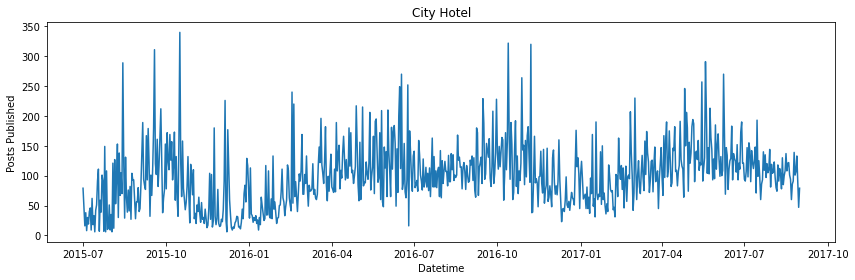

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(city)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('City Hotel')
plt.tight_layout()
plt.show()

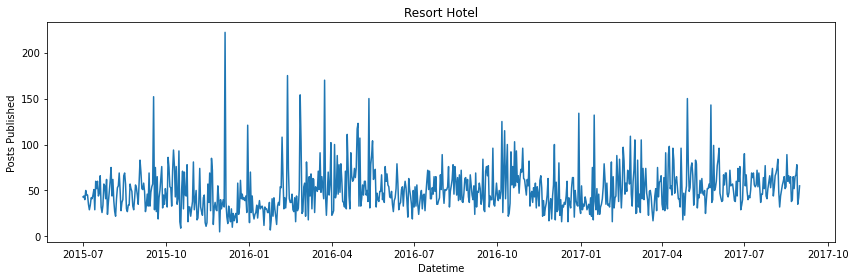

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(resort)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Resort Hotel')
plt.tight_layout()
plt.show()

The preliminary plots of the time series show even vagely the caracterics of the data. I can see that for the city hotel there is somewhat of an uptrend and semestrial seasonality, while the resort time series shows no trend but I'm not clear on seasonality. Let's show this in detail in the decomposition plot. 

<AxesSubplot:title={'center':'error'}, xlabel='arrival_date'>

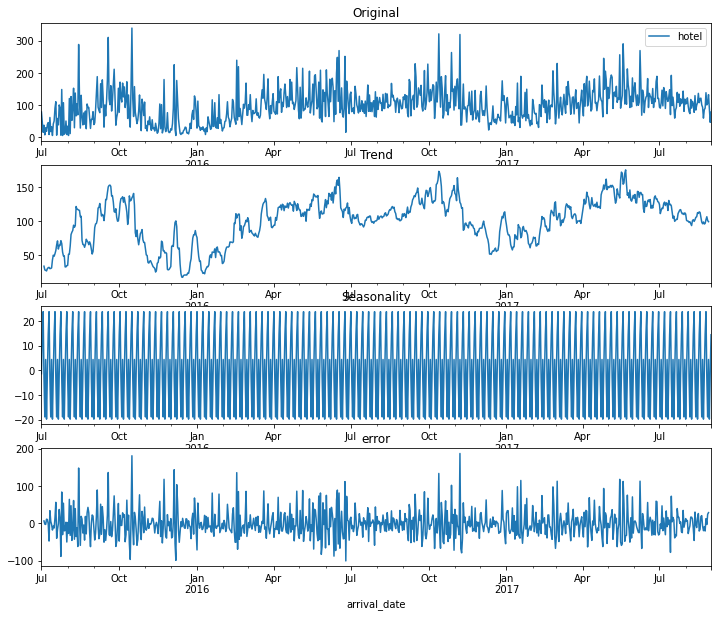

In [40]:
city_dec = sm.tsa.seasonal_decompose(city)
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
city.plot(title='Original', ax=axes[0])
city_dec.trend.plot(title='Trend', ax=axes[1])
city_dec.seasonal.plot(title='Seasonality', ax=axes[2])
city_dec.resid.plot(title='error', ax=axes[3])

For the city hotel, the decomposition plot shows a very slight uptrend, a weekly seasonality and a somewhat constant error.

<AxesSubplot:title={'center':'error'}, xlabel='arrival_date'>

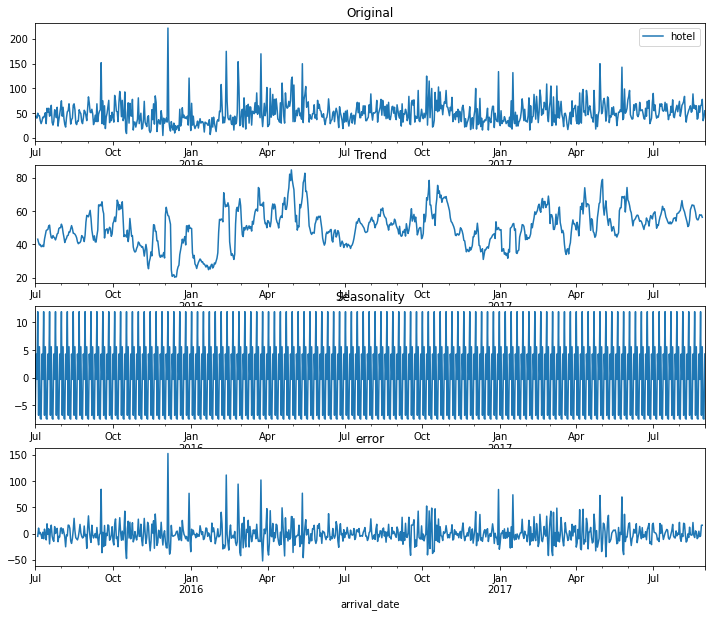

In [41]:
resort_dec = sm.tsa.seasonal_decompose(resort)
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
resort.plot(title='Original', ax=axes[0])
resort_dec.trend.plot(title='Trend', ax=axes[1])
resort_dec.seasonal.plot(title='Seasonality', ax=axes[2])
resort_dec.resid.plot(title='error', ax=axes[3])

The decomposition plot of the resort time series shows a constant trend, a weekly seasonality and a constant error.

# City Hotel

I will be using the last 4 months of the series as test samples.

In [42]:
city_train = city.loc[:'2017-05-31']
city_test = city.loc['2017-06-01':]

## ETS Model : Holt Winter's seasonal method

Since the decomposition plot for the city hotel showed a linear trend I'll be using an additive method for the trend component, the weekly seasonality doesn't change in magnitude over time suggesting an additive method for the seasonal component too.

In [43]:
hw = ExponentialSmoothing(city_train, seasonal_periods=7, trend='add', seasonal='add').fit()

In [44]:
hw_city_pred = hw.forecast(len(city_test))

In [45]:
hw_city_rmse = mean_squared_error(city_test, hw_city_pred, squared=False)

In [46]:
hw_city_mae = mean_absolute_error(city_test, hw_city_pred)

In [47]:
hw_city_rmse

49.70905065978191

In [48]:
hw_city_mae

42.6954079239807

In [49]:
def plot_forecast_city(forecast, model):
    plt.figure(figsize=(12,4))
    plt.plot(city_train, label='Training')
    plt.plot(city_test, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model}')
    plt.legend()
    plt.tight_layout()
    plt.show()

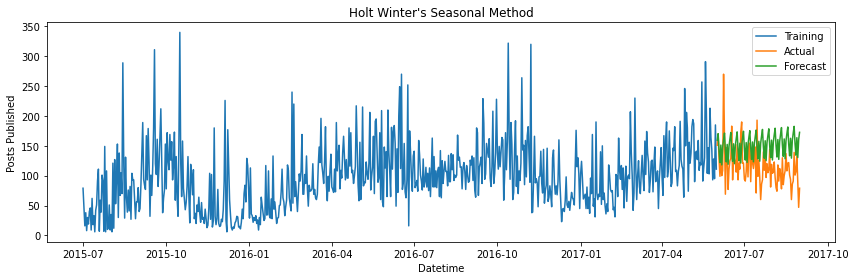

In [50]:
plot_forecast_city(hw_city_pred, "Holt Winter's Seasonal Method")

The plot above shows the forecasts of the ETS model against the actual values, from first glance it doesn't seem like a very good fit because the forecast don't take into account the decreasing number of bookings due to the low season, the magnitude of its seasonal component is also not going well with the observed values.

## Seasonal ARIMA

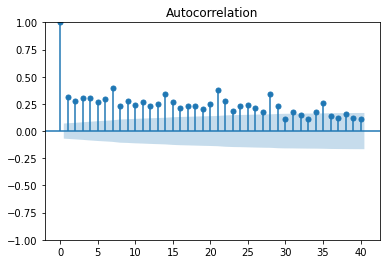

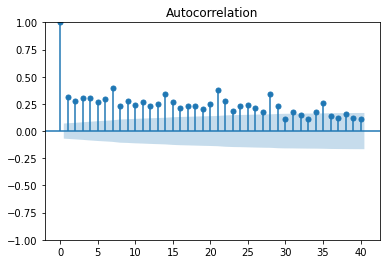

In [51]:
plot_acf(city, lags=40)

The ACF plot here shows strong correlation up to the 30th lag, suggesting that when the values go up they tend to keep going up and when they go down they tend to keep going down. I will go ahead and apply a first differencing and see if the series is staionarised. 

In [52]:
city_diff = city.diff()

In [53]:
city_diff = city_diff.dropna()

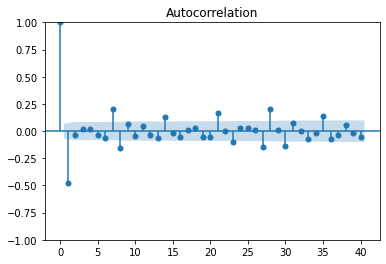

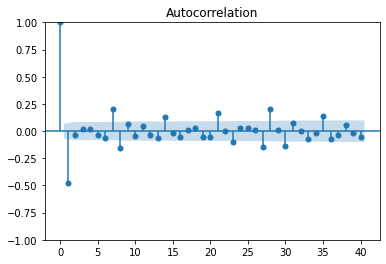

In [54]:
plot_acf(city_diff, lags=40)

The ACF shows only correlation at the first lag which cuts off quickly suggesting that the series is stationarised, it also suggests 1 AR term for the non seasonal part of ARIMA. The 7th lag has an important positive correlation suggesting 1 AR term for the seasonal part of ARIMA as well. 

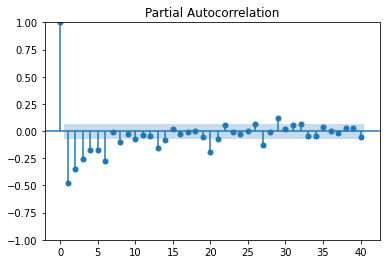

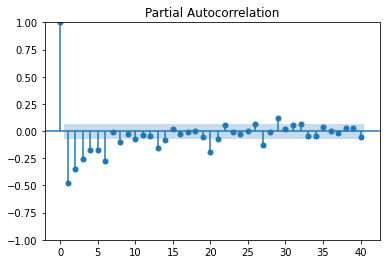

In [55]:
sm.graphics.tsa.plot_pacf(city_diff, lags=40,method='ywm')

The PACF confirms the finding of the ACF as in the 1 AR term for the non seasonal part because the the plot cuts off afetr the first lag. So as a recap , I will be using the following:
- Non seasonal ARIMA : (1,1,0)
- Seasonal ARIMA : (1, 0, 0)
- Frequency : 7

In [56]:
sarima = sm.tsa.statespace.SARIMAX(city_train, order=(1,1,0), seasonal_order=(1,0,0,7))

In [57]:
sarima.fit()

In [58]:
sarima = sm.tsa.statespace.SARIMAX(city_test, order=(1,1,0), seasonal_order=(1,0,0,7))

In [59]:
sarima_city_pred = sarima.fit().predict()

In [60]:
sarima_city_rmse = mean_squared_error(city_test, sarima_city_pred, squared=False)

In [61]:
sarima_city_mae = mean_absolute_error(city_test, sarima_city_pred)

In [62]:
sarima_city_rmse

41.50730953475121

In [63]:
sarima_city_mae

29.2417964726807

The error metrics show better result for ARIMA then ETS, let's see how well the forecast fits the actual values.

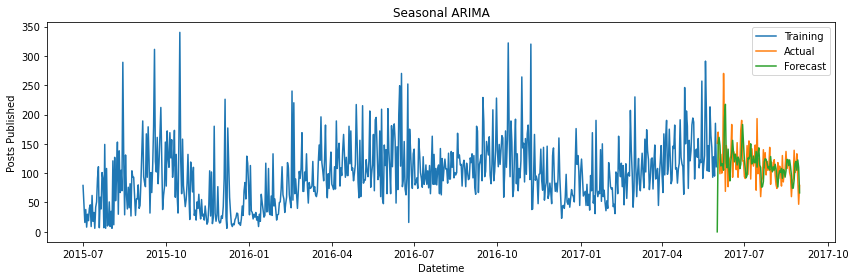

In [64]:
plot_forecast_city(sarima_city_pred, "Seasonal ARIMA")

The forecats alignes well with the actual values, it's much better than what ETS came up with. Let's try another model.

## Prophet Model

In [65]:
city_train = city_train.reset_index()
city_test = city_test.reset_index()

In [66]:
city_train = city_train.rename(columns={'arrival_date': 'ds','hotel': 'y'})
city_test = city_test.rename(columns={'arrival_date': 'ds','hotel': 'y'})

In [67]:
prophet = Prophet()
prophet.fit(city_train)

20:00:46 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
ds = city_test.drop(columns="y")

In [69]:
prophet_city_preds = prophet.predict(ds)

In [70]:
prophet_city_pred = prophet_city_preds["yhat"]

In [71]:
prophet_city_rmse =  mean_squared_error(city_test.y, prophet_city_pred, squared=False)
prophet_city_rmse

34.588259061559135

In [72]:
prophet_city_mae = mean_absolute_error(city_test.y, prophet_city_pred)
prophet_city_mae

25.441946718491657

The RMSE and MAE of teh prophet model are yet better than ARIMA, this is exciting because I didn't think I could lower the errors more on this time series.

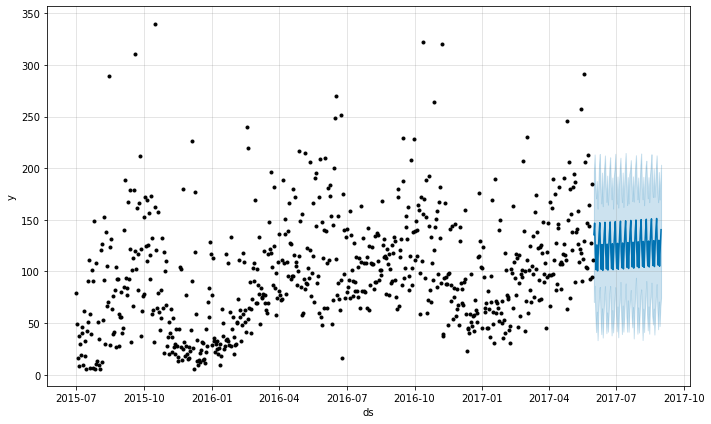

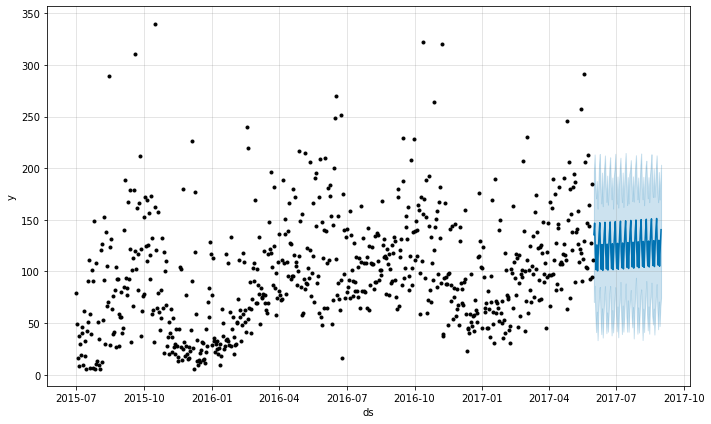

In [73]:
prophet.plot(prophet_city_preds)

And here we see the forecast plot that look also well aligned with the actual values.

## Comparing models' performances

In [74]:
rmse = [hw_city_rmse, sarima_city_rmse, prophet_city_rmse]
mae = [hw_city_mae, sarima_city_mae, prophet_city_mae]
models = ["Holt Winters", "SARIMA", "Prophet"]

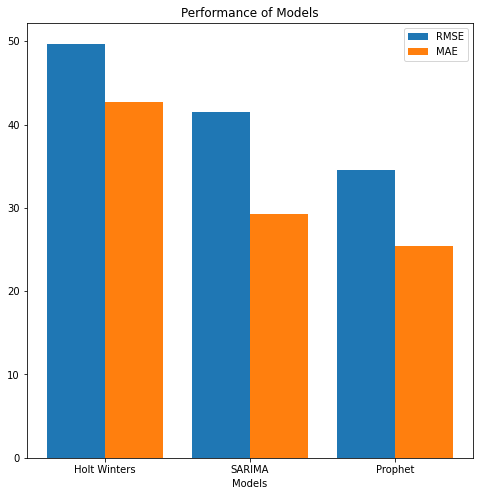

In [75]:
X_axis = np.arange(len(models))
plt.figure(figsize=(8, 8))  
plt.bar(X_axis - 0.2, rmse , 0.4, label = 'RMSE')
plt.bar(X_axis + 0.2, mae, 0.4, label = 'MAE')
  
plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.title("Performance of Models")
plt.legend()

The plot shows the RMSE and MAE values of the three models I attempted, I can clearly see that Prophet model is best suited of the city Hotel booking forecasts.

## Plotting the forecasts wth 95% confidence interval

In [76]:
city_residuals = sorted([x - y for x, y in zip(prophet_city_pred, city_test['y'].values)])

In [77]:
city_rmsfe = np.sqrt(sum([x**2 for x in city_residuals]) / len(city_residuals))
band_size = 1.96* city_rmsfe

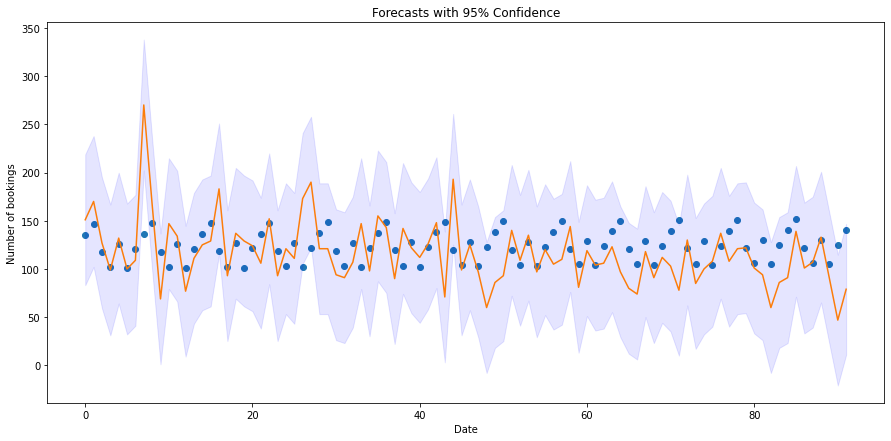

In [78]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(city_test.index, city_test['y'], color='#fc7d0b', label='Valid')
ax.scatter(city_test.index, prophet_city_pred)
ax.fill_between(city_test.index, (city_test['y']-band_size), (city_test['y']+band_size), color='b', alpha=.1)
ax.set_title("Forecasts with 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Number of bookings')
plt.show()

In the above I chose a confidence interval of 95% meaning that 95% of my forecasts are likely to fall within the intervals shown in light blue at the plot. I did this by calculating the RMSFE which is the same as the rmse only calculated over the residuals of the forecast. The RMSFE is a measure of the magnitude of a typical forecasting mistakes, and mupltiplying it with 1.96 (the normal standard deviation from the mean) it gives the interval in which the actual values will fall 95% of the time.

# Resort Hotel

Splitting train and test portions.

In [79]:
resort_train = resort.loc[:'2017-05-31']
resort_test = resort.loc['2017-06-01':]

## ETS Model

The decomposition plot of the resort hotel time series shows a very slight uptrend, although I'm inclined to consider it as a constant trend, and weekly seasonality that doesn't increase or decrease with time. So I'm going to use an additive term for the seasonality.

In [80]:
hw = ExponentialSmoothing(resort_train, seasonal_periods=7,  seasonal='add').fit()

In [81]:
hw_resort_pred = hw.forecast(len(resort_test))

In [82]:
hw_resort_rmse = mean_squared_error(resort_test, hw_resort_pred, squared=False)
hw_resort_rmse

12.612107854796179

In [83]:
hw_resort_mae = mean_absolute_error(resort_test, hw_resort_pred)
hw_resort_mae

10.197468599851131

The results of Holt Winters seasonal model are pretty low and impressive, I didn't think I could get these results on a first try. Let's plot the results to see how well they align with the data.

In [84]:
def plot_forecast_resort(forecast, model):
    plt.figure(figsize=(12,4))
    plt.plot(resort_train, label='Training')
    plt.plot(resort_test, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model}')
    plt.legend()
    plt.tight_layout()
    plt.show()

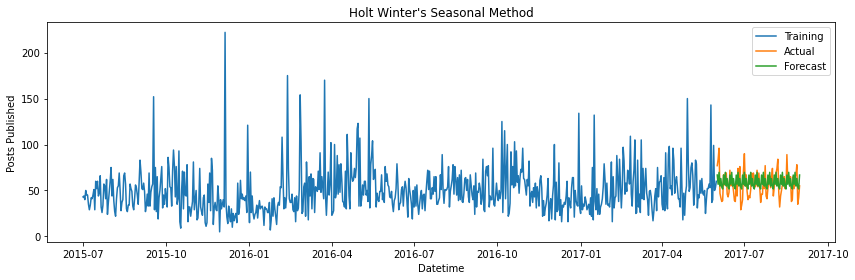

In [85]:
plot_forecast_resort(hw_resort_pred, "Holt Winter's Seasonal Method")

The plot shows that the forecasts don't align well with the ups and lows of the data but it's still good for a first try.

## Seasonal ARIMA

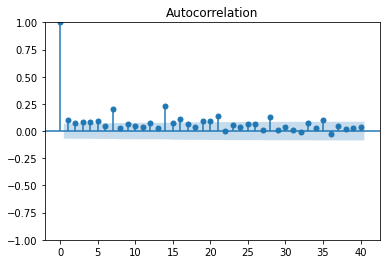

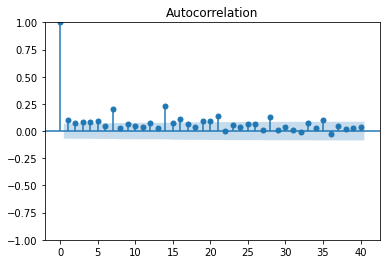

In [86]:
plot_acf(resort, lags=40)

The autocorrelation plot tells me that the series is stationary seen as there is isignificant correlation in most lags ACF. I will make sur of this with ADF test.

In [87]:
stat = adfuller(resort)
print('p-value: %f' % stat[1])

p-value: 0.001060


The ADF test confirms my intuition, it is less then .05 which means that the series is stationary. So I won't needing to difference this series at all.

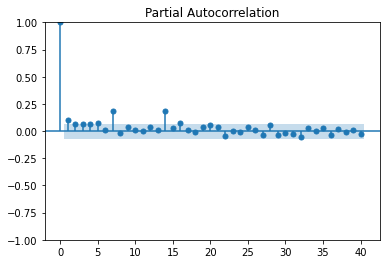

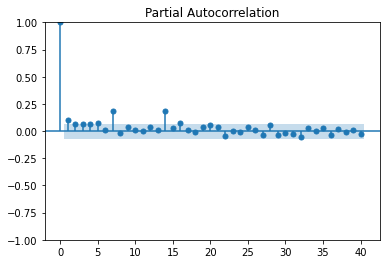

In [88]:
sm.graphics.tsa.plot_pacf(resort, lags=40,method='ywm')

The ACF and PACF tell me that I need to use 1 AR term for the non seasonal part of ARIMA (positive first lag), and 1 AR term for the seasonal part of ARIMA (first seasonal spike is positive). So I will be using the following:
- Non seasonal ARIMA (1,0,0)
- Seasonal ARIMA (1,0,0)*
- Frequency : 7

In [89]:
sarima = sm.tsa.statespace.SARIMAX(resort_train, order=(1,0,0), seasonal_order=(1,0,0,7))
sarima.fit()

In [90]:
sarima = sm.tsa.statespace.SARIMAX(resort_test, order=(1,0,0), seasonal_order=(1,0,0,7))
sarima_resort_pred = sarima.fit().predict()

In [91]:
sarima_resort_rmse = mean_squared_error(resort_test, sarima_resort_pred, squared=False)
sarima_resort_rmse

17.25724299974043

In [92]:
sarima_resort_mae = mean_absolute_error(resort_test, sarima_resort_pred)
sarima_resort_mae

12.405502817101407

So the error metrics show a better job done by the ETS model, the error is higher for ARIMA, let's see how the forecasts fit the observed values

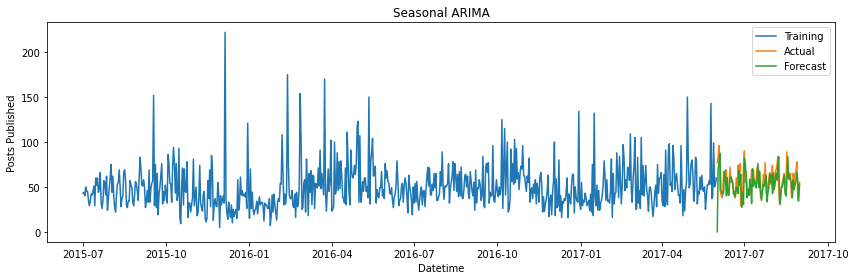

In [93]:
plot_forecast_resort(sarima_resort_pred, "Seasonal ARIMA")

Here I can see why the error is higher for ARIMA, it's because it aligned too much with ups and lows of the data while sometimes exceeds the magnitude of the said ups and downs. Even though ARIMA has higher error I would choose it over ETS because it capture the movement of the data.

## Prophet model

In [94]:
resort_train = resort_train.reset_index()
resort_test = resort_test.reset_index()

In [95]:
resort_train = resort_train.rename(columns={'arrival_date': 'ds','hotel': 'y'})
resort_test = resort_test.rename(columns={'arrival_date': 'ds','hotel': 'y'})

In [96]:
prophet = Prophet()

In [97]:
prophet.fit(resort_train)

20:00:49 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
ds = resort_test.drop(columns="y")
prophet_resort_preds = prophet.predict(ds)
prophet_resort_pred = prophet_resort_preds["yhat"]

In [99]:
prophet_resort_rmse =  mean_squared_error(resort_test.y, prophet_resort_pred, squared=False)
prophet_resort_rmse

12.65427252913778

In [100]:
prophet_resort_mae = mean_absolute_error(resort_test.y, prophet_resort_pred)
prophet_resort_mae

10.241178156712884

The results obtained by Prophet are better than those of ARIMA and only very slightly lower than ETS.

## Comparing models' performances

In [101]:
rmse = [hw_resort_rmse, sarima_resort_rmse, prophet_resort_rmse]
mae = [hw_resort_mae, sarima_resort_mae, prophet_resort_mae]
models = ["Holt Winters", "SARIMA", "Prophet"]

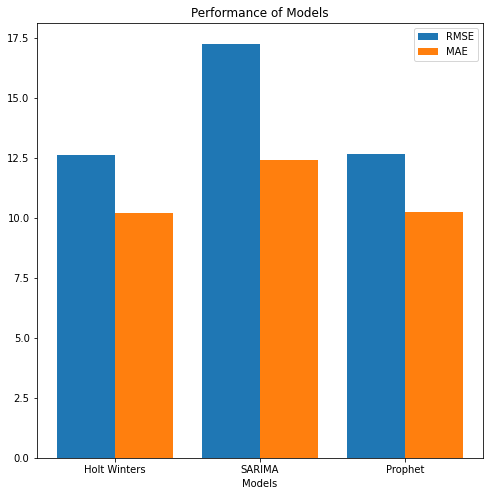

In [102]:
X_axis = np.arange(len(models))
plt.figure(figsize=(8, 8))  
plt.bar(X_axis - 0.2, rmse , 0.4, label = 'RMSE')
plt.bar(X_axis + 0.2, mae, 0.4, label = 'MAE')
  
plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.title("Performance of Models")
plt.legend()

The errors of my models are shown above, I can see that Holt Winter's method and prophet have very close score although the ETS model is better.

## Plotting the forecasts wth 95% confidence interval

In [103]:
resort_residuals = sorted([x - y for x, y in zip(hw_resort_pred, resort_test['y'].values)])

In [104]:
resort_rmsfe = np.sqrt(sum([x**2 for x in resort_residuals]) / len(resort_residuals))
band_size = 1.96* resort_rmsfe

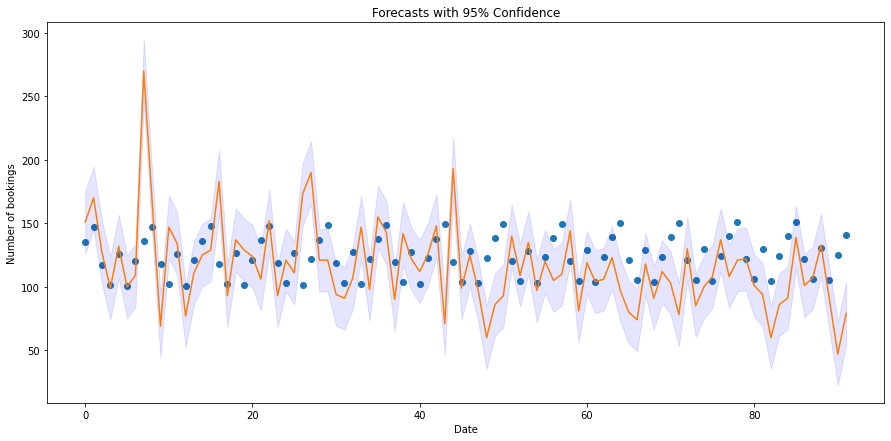

In [107]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(city_test.index, city_test['y'], color='#fc7d0b', label='Valid')
ax.scatter(city_test.index, prophet_city_pred)
ax.fill_between(city_test.index, (city_test['y']-band_size), (city_test['y']+band_size), color='b', alpha=.1)
ax.set_title("Forecasts with 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Number of bookings')
plt.show()

And right above I can see my predictions using Holt Winter's method with a 95% confidence interval.

# Conclusion

In this notebook I have gone through the City and Resort Hotels dataset, which contained a lot information about the bookings made in these two hotels. I tried to figure out some of the trends and properties of my dataset before I used 3 forecasting models to try and forecast the number of bookings the hotels are likely to receive based on their previous bookings. 
To gain insight into the time series I used the decomposition plot, ACF, PCF and the addfuller test. To make forecasts I used ETS models, ARIMA models and Prophet models and for evaluation I used the the RMSE, MAE and RMSFE. Finally after choosing my model I made forecats using a confidence interval of 95%.